In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn import model_selection, preprocessing, linear_model, neighbors, ensemble, neural_network, metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, OrdinalEncoder
from copy import deepcopy

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from utils import classification_util as cu

## Load Data

In [3]:
data_path = r'data/Loan/loan-10k.lrn.csv'
df = pd.read_csv(data_path)
df

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6644,20000.0,20000.0,20000.0,60 months,16.02,486.58,5 years,OWN,54000.0,...,N,8,2017,11,1991,2,2019,2,2019,C
9996,25910,7500.0,7500.0,7500.0,36 months,9.49,240.22,10+ years,RENT,46386.0,...,N,10,2014,4,2004,3,2017,6,2018,B
9997,95698,20750.0,20750.0,20750.0,60 months,15.05,494.19,< 1 year,RENT,185000.0,...,N,4,2017,2,2004,2,2019,2,2019,C
9998,27371,11000.0,11000.0,11000.0,60 months,16.29,269.20,1 year,RENT,38500.0,...,N,9,2014,8,2006,3,2016,10,2016,D


## 2. Exploration

In [4]:
df.describe()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,total_bc_limit,total_il_high_credit_limit,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,...,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50043.430200,15631.152500,15631.152500,15625.992500,13.216959,461.084183,8.212897e+04,19.089188,0.303400,698.179500,...,2.423097e+04,48294.371800,5.77670,2016.003100,5.724600,2000.017900,4.003000,2017.747300,3.334200,2018.453400
std,28982.440166,9314.246117,9314.246117,9312.426843,4.855838,269.903751,6.769284e+04,9.523219,0.841201,32.170977,...,2.539548e+04,46981.179499,3.40482,1.587496,3.382558,7.302583,3.224257,1.463235,2.909666,0.963494
min,0.000000,1000.000000,1000.000000,1000.000000,5.310000,30.120000,5.000000e+03,0.000000,0.000000,660.000000,...,2.000000e+02,0.000000,0.00000,2012.000000,0.000000,1965.000000,0.000000,2012.000000,0.000000,2012.000000
25%,24873.250000,8350.000000,8350.000000,8343.750000,9.750000,263.770000,5.000000e+04,12.437500,0.000000,675.000000,...,8.800000e+03,18881.250000,3.00000,2015.000000,3.000000,1996.000000,2.000000,2017.000000,2.000000,2018.000000
50%,50033.500000,14000.000000,14000.000000,14000.000000,12.730000,396.780000,7.000000e+04,18.330000,0.000000,690.000000,...,1.710000e+04,36533.500000,6.00000,2016.000000,6.000000,2001.000000,2.000000,2018.000000,2.000000,2019.000000
75%,75261.500000,21000.000000,21000.000000,21000.000000,16.010000,616.337500,9.700000e+04,24.930000,0.000000,715.000000,...,3.140000e+04,63500.500000,9.00000,2017.000000,9.000000,2005.000000,6.000000,2019.000000,3.000000,2019.000000
max,99999.000000,40000.000000,40000.000000,40000.000000,30.990000,1717.630000,3.200000e+06,168.520000,16.000000,845.000000,...,1.090700e+06,768775.000000,11.00000,2018.000000,11.000000,2015.000000,11.000000,2019.000000,11.000000,2019.000000


Attribute 'policiy_code' always has the same value -> carries no information for training

In [5]:
display(df.policy_code.describe())
# df.drop("policy_code", axis=1, inplace=True)

count    10000.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: policy_code, dtype: float64

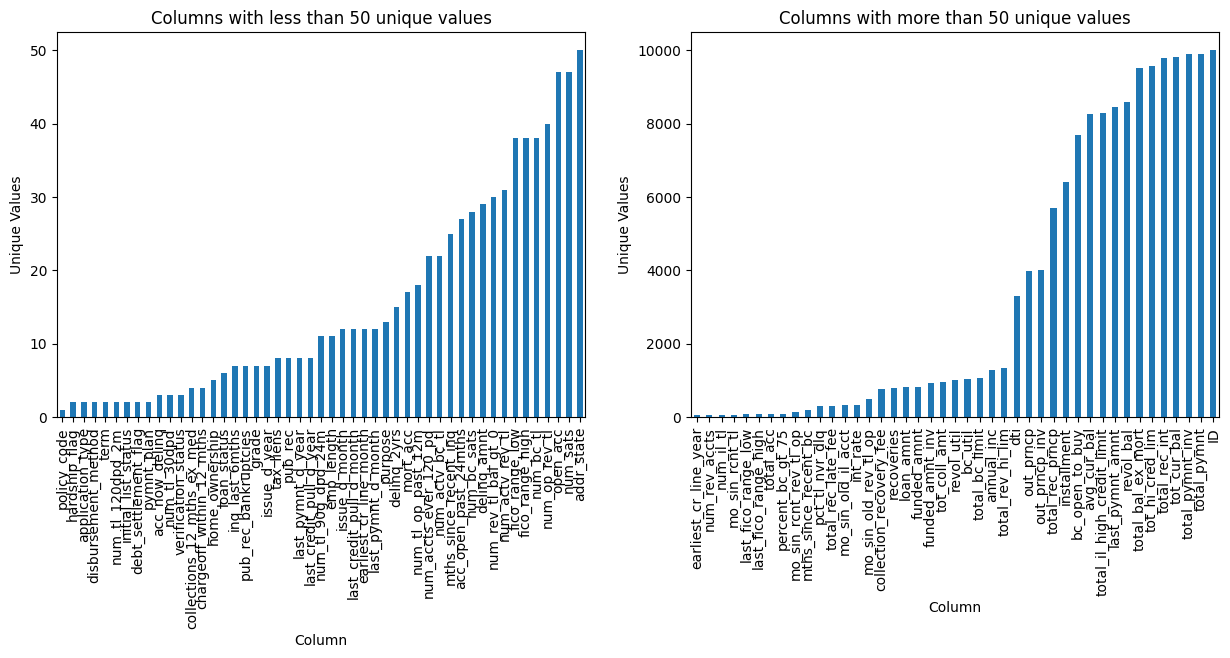

In [6]:
unique_values = df.nunique().sort_values()

less_than_50 = unique_values[unique_values <= 50]
more_than_50 = unique_values[unique_values > 50]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

less_than_50.plot(kind='bar', ax=ax1)
ax1.set_title('Columns with less than 50 unique values')

more_than_50.plot(kind='bar', ax=ax2)
ax2.set_title('Columns with more than 50 unique values')

for ax in [ax1, ax2]:
    ax.set_xlabel('Column')
    ax.set_ylabel('Unique Values')

plt.show()

<Axes: >

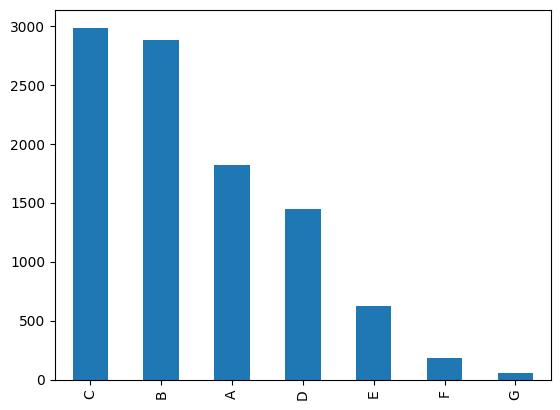

In [7]:
df['grade'].value_counts().plot(kind='bar')

In [8]:
df.select_dtypes(object)

,term,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag,grade
0,36 months,< 1 year,MORTGAGE,Not Verified,Current,n,debt_consolidation,IL,w,Individual,N,Cash,N,A
1,60 months,1 year,MORTGAGE,Source Verified,Current,n,debt_consolidation,OK,f,Individual,N,Cash,N,E
2,60 months,< 1 year,RENT,Not Verified,Fully Paid,n,debt_consolidation,AZ,w,Individual,N,Cash,N,D
3,36 months,9 years,RENT,Source Verified,Charged Off,n,debt_consolidation,CA,f,Individual,N,Cash,N,C
4,36 months,1 year,MORTGAGE,Source Verified,Current,n,debt_consolidation,FL,w,Individual,N,Cash,N,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,60 months,5 years,OWN,Verified,Current,n,debt_consolidation,NJ,w,Individual,N,Cash,N,C
9996,36 months,10+ years,RENT,Source Verified,Charged Off,n,credit_card,NY,w,Individual,N,Cash,N,B
9997,60 months,< 1 year,RENT,Source Verified,Current,n,debt_consolidation,OR,w,Individual,N,Cash,N,C
9998,60 months,1 year,RENT,Source Verified,Charged Off,n,medical,CA,w,Individual,N,Cash,N,D


<Axes: xlabel='int_rate', ylabel='grade'>

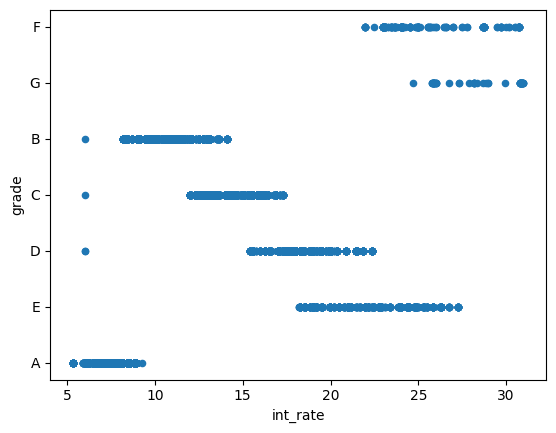

In [9]:
df.plot.scatter(x='int_rate', y ='grade')

In [10]:
# df_loc.hist(bins=30, figsize=(150,100))

In [11]:
# for c in df_loc.columns:
#     df_loc.plot.scatter(x=c, y ='grade')
# # df_loc = df_loc[df_loc.int_rate != 6.0]
# # df_loc.plot.scatter(x='int_rate', y ='grade')

In [12]:
#dti, last_fico_range_low have outliers but dont seem to be relevant features

# df_loc.plot.scatter(x='dti', y ='grade')
# plt.show()
# df_loc['dti'].hist()
# plt.show()
# df_loc['last_fico_range_low'].hist()
# plt.show()
# df_loc.plot.scatter(x='last_fico_range_low', y ='grade')

In [13]:
# from scipy.stats import zscore
# z = df_loc.apply(zscore)
# z = np.abs(z)
# z.max()[z.max()>50]
# df_loc['home_ownership_ANY'].hist()
df

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6644,20000.0,20000.0,20000.0,60 months,16.02,486.58,5 years,OWN,54000.0,...,N,8,2017,11,1991,2,2019,2,2019,C
9996,25910,7500.0,7500.0,7500.0,36 months,9.49,240.22,10+ years,RENT,46386.0,...,N,10,2014,4,2004,3,2017,6,2018,B
9997,95698,20750.0,20750.0,20750.0,60 months,15.05,494.19,< 1 year,RENT,185000.0,...,N,4,2017,2,2004,2,2019,2,2019,C
9998,27371,11000.0,11000.0,11000.0,60 months,16.29,269.20,1 year,RENT,38500.0,...,N,9,2014,8,2006,3,2016,10,2016,D


In [14]:
from sklearn.model_selection import train_test_split
     

In [15]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder

def calculate_month_difference(month, year):
    target_month = 0  # January
    target_year = 2023

    total_months = (target_year - year) * 12  # Calculate the total months based on the difference in years
    total_months += target_month - month  # Add the remaining months from the target month

    return abs(total_months)

def transform_encode(X_te, X_tr, enc_type):
    log_features = ['int_rate', 'annual_inc', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit']
    c_root_tranform_col = ['installment', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                                'total_il_high_credit_limit', 'total_bal_ex_mort', 'avg_cur_bal', 'bc_open_to_buy', 
                                'revol_bal', 'total_rec_int', 'last_pymnt_amnt', 'tot_coll_amt','tot_cur_bal']

    months = []
        
    if enc_type == 'one_hot':
        preprocessor = ColumnTransformer([
            ('log', FunctionTransformer(np.log), log_features),
            ('c_root', FunctionTransformer(np.cbrt), c_root_tranform_col),
            ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), list(X_tr.select_dtypes('object').columns)+months)])
    elif enc_type in ['mix', 'loc']:
        for x in [X_te, X_tr]:
            x['emp_length'].replace({ '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,    
                '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}, inplace=True)
            x['loan_status'].replace({'Charged Off': 0, 'Current': 1,'Fully Paid': 2, 'In Grace Period': 3,  
                'Late (16-30 days)': 4, 'Late (31-120 days)': 5}, inplace=True) #TODO check if removed from loan status dtype not object anymore
            if enc_type == 'loc':
                data_path_loc = r'data/Loan/states.csv'
                loc = pd.read_csv(data_path_loc, sep='\t')
                loc.columns
                loc = loc.drop('name', axis=1)
                x = pd.merge(x, loc, on="addr_state")
                x = x.drop('addr_state', axis=1)    
        preprocessor = ColumnTransformer([
            ('log', FunctionTransformer(np.log), log_features),
            ('c_root', FunctionTransformer(np.cbrt), c_root_tranform_col),
            ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), list(X_tr.select_dtypes('object').columns) + months)])
    elif enc_type == 'label':
        preprocessor = ColumnTransformer([
            ('log', FunctionTransformer(np.log), log_features),
            ('c_root', FunctionTransformer(np.cbrt), c_root_tranform_col),
            ('label', LabelEncoder(), list(X_tr.select_dtypes('object').columns))])
    else:
        print("ERROR n valid enc_type")
    return X_te, X_tr, preprocessor

# df = df[df.int_rate != 6.0] TODO outlier

# # label encode grade TODO
# if 'grade' in df:
#     df['grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,}, inplace=True)




In [16]:
def train_test(X, y, kaggle):
    if kaggle:
        X_tr = X.copy()
        y_tr = y.copy()
        X_te = pd.read_csv('data/Loan/loan-10k.tes.csv')
        X_te_id = X_te.pop('ID')
        X_tr_id = X_tr.pop('ID')
        return X_tr, X_te, y_tr, None, X_te_id, X_tr_id
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X,y, random_state=42, stratify=y, test_size=0.2)
        X_te_id = X_te.pop('ID')
        X_tr_id = X_tr.pop('ID')
        return X_tr, X_te, y_tr, y_te, X_te_id, X_tr_id

In [30]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, OrdinalEncoder

def encode_data(X_tr, X_te, how):
    col = list(X_tr.select_dtypes('object').columns)
    if how == 'label':
        enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_tr[col] = enc.fit_transform(X_tr[col])
        X_te[col] = enc.transform(X_te[col])
    if how =='one_hot':
        enc = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='error')
        encoded_array = enc.fit_transform(X_tr.loc[:,col])
        X_tr_encoded = pd.DataFrame(encoded_array,columns=enc.get_feature_names_out() )
        X_tr = X_tr.assign(row_number=range(len(X_tr)))
        X_tr_encoded = X_tr_encoded.assign(row_number=range(len(X_tr_encoded)))
        X_tr_sklearn_encoded = pd.merge(X_tr, X_tr_encoded, on='row_number')
        X_tr_sklearn_encoded.drop(labels= col+['row_number'],axis=1,inplace=True)
        X_tr = X_tr_sklearn_encoded

        encoded_array = enc.transform(X_te.loc[:,col])
        X_te_encoded = pd.DataFrame(encoded_array,columns=enc.get_feature_names_out())
        X_te = X_te.assign(row_number=range(len(X_te)))
        X_te_encoded = X_te_encoded.assign(row_number=range(len(X_te_encoded)))
        X_te_sklearn_encoded = pd.merge(X_te, X_te_encoded, on='row_number')
        X_te_sklearn_encoded.drop(labels= col+['row_number'],axis=1,inplace=True)
        X_te = X_te_sklearn_encoded
    if how == 'mix':
        for x in [X_tr, X_te]:
            x['emp_length'].replace({ '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,    
                '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}, inplace=True)
            x['loan_status'].replace({'Charged Off': 0, 'Current': 1,'Fully Paid': 2, 'In Grace Period': 3,  
                'Late (16-30 days)': 4, 'Late (31-120 days)': 5, 'Default': -1}, inplace=True)
            x.drop(labels=['addr_state'], axis=1, inplace=True)
        col = list(X_tr.select_dtypes('object').columns)

        enc = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
        encoded_array = enc.fit_transform(X_tr.loc[:,col])
        X_tr_encoded = pd.DataFrame(encoded_array,columns=enc.get_feature_names_out() )
        X_tr = X_tr.assign(row_number=range(len(X_tr)))
        X_tr_encoded = X_tr_encoded.assign(row_number=range(len(X_tr_encoded)))
        X_tr_sklearn_encoded = pd.merge(X_tr, X_tr_encoded, on='row_number')
        X_tr_sklearn_encoded.drop(labels= col+['row_number'],axis=1,inplace=True)
        X_tr = X_tr_sklearn_encoded

        encoded_array = enc.transform(X_te.loc[:,col])
        X_te_encoded = pd.DataFrame(encoded_array,columns=enc.get_feature_names_out())
        X_te = X_te.assign(row_number=range(len(X_te)))
        X_te_encoded = X_te_encoded.assign(row_number=range(len(X_te_encoded)))
        X_te_sklearn_encoded = pd.merge(X_te, X_te_encoded, on='row_number')
        X_te_sklearn_encoded.drop(labels= col+['row_number'],axis=1,inplace=True)
        X_te = X_te_sklearn_encoded
        display(X_tr)
    return X_tr, X_te

In [18]:
def transformer(X_tr, X_te):
        log_tranform_col = ['int_rate', 'annual_inc', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit']
        c_root_tranform_col = ['installment', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                            'total_il_high_credit_limit', 'total_bal_ex_mort', 'avg_cur_bal', 'bc_open_to_buy', 
                            'revol_bal', 'total_rec_int', 'last_pymnt_amnt', 'tot_coll_amt','tot_cur_bal']

        for col in c_root_tranform_col:
            X_tr[col] = np.cbrt(X_tr[col])
            X_te[col] = np.cbrt(X_te[col])
        for col in log_tranform_col:
            X_tr[col] = np.log(X_tr[col])
            X_te[col] = np.log(X_te[col])
        return X_tr, X_te

In [32]:
kaggle = False
encoding = 'label'
scaling = True
oversampling = True
transform = True
rm_outlier = False
do_holdout = False

data = df.copy()

if rm_outlier:
    data = data[data.int_rate != 6.0]

y = data.pop('grade')
X = data

X_tr, X_te, y_tr, y_te, X_te_id, X_tr_id = train_test(X, y, kaggle)

if transform:
    X_tr, X_te = transformer(X_tr, X_te)
    
X_tr, X_te = encode_data(X_tr, X_te, encoding)

preprocessing_steps = []
if scaling:
    scaler = preprocessing.StandardScaler()
    preprocessing_steps.append(('standard_scaling', scaler))

if oversampling:
    ros = RandomOverSampler(random_state=0, sampling_strategy='not majority')
    preprocessing_steps.append(('random_sampler', ros))

methods = [ 
    ('KNN', neighbors.KNeighborsClassifier()), 
    ('DT', DecisionTreeClassifier()),#],#,#, #criterion='entropy', max_depth=20, min_samples_leaf=1, min_samples_split=2
    ('MLP', neural_network.MLPClassifier())]

pipelines = {}
for method in methods:
    pipeline_steps = deepcopy(preprocessing_steps)
    pipeline_steps.append(method)
    pipeline = Pipeline(pipeline_steps)
    name, cl = method
    pipelines[name] = pipeline
scores = []

# for pipeline in pipelines.values():
#     pipeline
#     pipeline.fit(X_tr, y_tr)
#     y_pred = pipeline.predict(X_te)
#     # display(metrics.accuracy_score(y_te, y_pred))
#     scores = [
#         metrics.confusion_matrix(y_te, y_pred), 
#         metrics.precision_recall_fscore_support(y_te, y_pred, average='macro'),
#         metrics.accuracy_score(y_te, y_pred)]
#     for score in scores:
#         display(score)


In [27]:
models = {}

In [28]:
from utils import classification_util as cu

knn_params = {'KNN__n_neighbors': [1, 2, 3, 5, 7, 10, 20, 30, 40, 50, 100, 200, 300, 1000, 2000, 5000], 
              'KNN__weights': ['distance'],
              'KNN__p': [1, 2],
             }
models['KNN'] = cu.perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['KNN'], knn_params, do_holdout)

'doing holdout'

KeyError: '[1578 2126 5007 ... 3772 5191 5390] not in index'

In [45]:
from utils import classification_util as cu

mlp_params = {
    'MLP__hidden_layer_sizes': [(50, 10), (50, 50), (30, 30), (20, 20), (40, 10)],
    'MLP__activation': ['relu'],
    'MLP__solver': ['adam'],
    'MLP__alpha': [0.0001, 0.001],
    'MLP__learning_rate': ['adaptive'],
    'MLP__max_iter': [500]
}

models['MLP'] = cu.perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['MLP'], mlp_params, do_holdout)

'doing holdout'

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 50), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  13.4s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  16.7s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(30, 30), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  19.3s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(40, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  16.5s
[CV] END MLP__activation=relu, MLP__alpha=0.001, MLP__hidden_layer_sizes=(50, 10), MLP__learning_rate=adaptive, MLP__max_iter=500, MLP__solver=adam; total time=  15.4s
[CV] END MLP__activation=relu, MLP__alpha=0.0001, MLP__hidden_layer_sizes=(20, 20), MLP__learni

{'MLP__activation': 'relu',
 'MLP__alpha': 0.001,
 'MLP__hidden_layer_sizes': (20, 20),
 'MLP__learning_rate': 'adaptive',
 'MLP__max_iter': 500,
 'MLP__solver': 'adam'}

90.2147319316864


90.2147319316864

array([[346,  18,   0,   0,   0,   0,   0],
       [ 22, 525,  29,   0,   0,   0,   0],
       [  0,  25, 550,  23,   0,   0,   0],
       [  0,   0,  21, 243,  22,   3,   1],
       [  0,   0,   0,  19,  86,  17,   2],
       [  0,   0,   0,   1,  14,  18,   4],
       [  0,   0,   0,   0,   3,   6,   2]])

acc: 0.885
balanced_acc: 0.7116463307483654
prfs: (0.7071633305117689, 0.7116463307483654, 0.7086202643905616, None)



In [46]:
DT_params = {
    'DT__max_depth': [None, 5, 10, 20, 50, 100],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [1, 2, 4]
}

models['DT'] = cu.perform_gridsearch(X_tr, y_tr, X_te, y_te, pipelines['DT'], DT_params, do_holdout)

'doing holdout'

Fitting 1 folds for each of 54 candidates, totalling 54 fits
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=5; total time=   0.4s
[CV] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2; total time=   0.4s
[CV] END DT__max_depth=None, DT__min_samples_leaf=2, DT__min_samples_split=2; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=2, DT__min_samples_split=5; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=2, DT__min_samples_split=10; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=4, DT__min_samples_split=2; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=4, DT__min_samples_split=5; total time=   0.3s
[CV] END DT__max_depth=None, DT__min_samples_leaf=4, DT__min_samples_split=10; total time=   0.3s
[CV] END DT__max_depth=5, DT__min_samples_leaf=1, DT__min_sampl

{'DT__max_depth': 50, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}

0.33667778968811035


0.33667778968811035

array([[361,   3,   0,   0,   0,   0,   0],
       [  1, 575,   0,   0,   0,   0,   0],
       [  0,   3, 595,   0,   0,   0,   0],
       [  0,   0,   1, 282,   7,   0,   0],
       [  0,   0,   0,   5, 112,   7,   0],
       [  0,   0,   0,   0,   5,  31,   1],
       [  0,   0,   0,   0,   0,   0,  11]])

acc: 0.9835
balanced_acc: 0.9569261208045718
prfs: (0.9433561483359426, 0.9569261208045718, 0.9498534325268969, None)

